<a href="https://colab.research.google.com/github/cmlakhan/ml_code/blob/master/text_generation_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import urllib.request

from __future__ import unicode_literals, print_function, division
import unicodedata
import string

import torch
import torch.nn as nn

import random
import time
import math



In [4]:
def convertASCII(word):
    asciiWord = ""
    word = str(word).rstrip()
    for c in word:
        if c in characterMap.keys():
            asciiWord = asciiWord + characterMap[c]
        else:
            asciiWord = asciiWord + c
    return asciiWord;


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device='cuda')

def train(category_tensor, input_line_tensor, target_line_tensor, optimizer):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    optimizer.zero_grad()


    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=2.0, norm_type=2)
    optimizer.step()

    loss_val = loss.detach().cpu().numpy() / input_line_tensor.size(0)

    return output, loss_val

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        hidden = hidden.to('cpu')

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))




In [5]:

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  # Plus EOS marker

list_names = ['Arabic', 'Chinese', 'Czech', 'Dutch',
              'English', 'French', 'German', 'Greek',
              'Irish', 'Italian', 'Japanese', 'Korean',
              'Polish', 'Portuguese', 'Russian', 'Scottish',
              'Spanish', 'Vietnamese']



In [14]:

data = []
for ethnicity in list_names:
    url = "https://github.com/cmlakhan/ml_code/raw/master/sequential_modeling/data/names/{}.txt".format(ethnicity)
    file = urllib.request.urlopen(url)

    for line in file:
        data.append({'name': line.decode('utf-8'), 'ethnicity':ethnicity})


names_df = pd.DataFrame(data)
all_categories = names_df.ethnicity.unique().tolist()
n_categories = len(all_categories)


names_df[['name_ascii']] = names_df.name.apply(lambda x: unicodeToAscii(x))


In [15]:
names_df.head()


,name,ethnicity,name_ascii
0,Khoury\n,Arabic,Khoury
1,Nahas\n,Arabic,Nahas
2,Daher\n,Arabic,Daher
3,Gerges\n,Arabic,Gerges
4,Nazari\n,Arabic,Nazari


In [16]:


rnn = RNN(n_letters, 512, n_letters)
criterion = nn.NLLLoss()
learning_rate = 0.0005
frac = 1.00
num_epochs = 2

print_every = 1000
plot_every = 200
all_losses = []
total_loss = 0 # Reset every plot_every iters


start = time.time()
device = 'cuda'

rnn.to(device)

optimizer = torch.optim.AdamW(rnn.parameters(), lr=learning_rate, weight_decay=0.00001, amsgrad=False)


In [17]:

iter = 0
for i in range(1,num_epochs+1):
    print('Epoch #{}'.format(i))
    subset_df = names_df.sample(frac=frac)
    len_df = subset_df.shape[0]
    for index,row in subset_df.iterrows():
        iter += 1
        category_tensor = categoryTensor(row.ethnicity)
        input_line_tensor = inputTensor(row.name_ascii)
        target_line_tensor = targetTensor(row.name_ascii)
        category_tensor = category_tensor.to(device)
        input_line_tensor = input_line_tensor.to(device)
        target_line_tensor = target_line_tensor.to(device)
        output, loss = train(category_tensor, input_line_tensor, target_line_tensor, optimizer)
        total_loss += loss
        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / len_df * 100, loss))
        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0



Epoch #1
0m 4s (1000 4%) 2.9466
0m 9s (2000 9%) 2.5848
0m 14s (3000 14%) 2.3064
0m 19s (4000 19%) 2.0766
0m 24s (5000 24%) 2.8925
0m 29s (6000 29%) 2.6664
0m 34s (7000 34%) 2.1562
0m 39s (8000 39%) 2.2858
0m 44s (9000 44%) 1.5953
0m 49s (10000 49%) 2.0796
0m 53s (11000 54%) 2.6860
0m 58s (12000 59%) 2.2077
1m 3s (13000 64%) 2.7254
1m 8s (14000 69%) 1.6346
1m 13s (15000 74%) 2.7721
1m 18s (16000 79%) 3.6822
1m 23s (17000 84%) 1.5948
1m 27s (18000 89%) 1.8411
1m 32s (19000 94%) 3.2409
1m 37s (20000 99%) 2.7277
Epoch #2
1m 42s (21000 104%) 2.0885
1m 47s (22000 109%) 2.6189
1m 52s (23000 114%) 3.1790
1m 57s (24000 119%) 2.4154
2m 1s (25000 124%) 2.9946
2m 6s (26000 129%) 2.0383
2m 11s (27000 134%) 3.1186
2m 16s (28000 139%) 2.0506
2m 21s (29000 144%) 2.0248
2m 26s (30000 149%) 2.9264
2m 31s (31000 154%) 2.4684
2m 35s (32000 159%) 2.2894
2m 40s (33000 164%) 2.3709
2m 45s (34000 169%) 2.6900
2m 50s (35000 174%) 2.6293
2m 55s (36000 179%) 1.7102
3m 0s (37000 184%) 2.0464
3m 5s (38000 189%) 2.

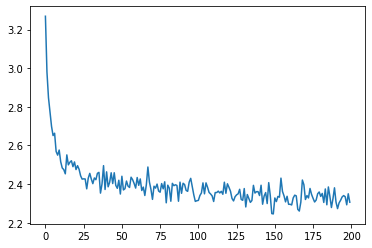

In [18]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)


In [19]:

max_length = 20
rnn.to('cpu')
samples('Arabic', 'RUS')



Raham
Usham
Shama
